<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> Multinomial Regression</p>

*Import Libraries*

In [233]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC


# import others
import os
import pickle
import warnings
from itertools import combinations


In [114]:
# Specific warning categories to be ignored
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

*Import data from initial EDA*

In [115]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Split data and prepare labels*

In [116]:
ALL_FEATURES = ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
                'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
                'Daily Steps', 'Blood Pressure Category']
X = df[ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [117]:
# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# check new values in consolidated column
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])

In [118]:
# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*Preprocess steps*

In [120]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns),
        ('scale', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# # Check ohe and scaled datasets
# display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
# display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

*Create pipeline and base model*

In [156]:
# create model
model_mlr = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42) # default solver "lgbgs" and penalty "l2"

# create sklearn pipeline
pipeline_mlr = settings.create_pipeline(["preprocess", column_trans], ["multinomial_logistic_regression", model_mlr])  

# create cross validation object for cross_val_score
cv_mlr = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# define custom scorer for this work: positive label (class 1 and 2) F1 score
base_scorer = settings.CustomPositiveF1Scorer().scorer_function
custom_scorer = settings.CustomPositiveF1Scorer().custom_scorer

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_mlr, X_train, y_train, scoring=custom_scorer, cv=cv_mlr)

settings.cross_val_summary(pipeline_mlr, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)


Train Score: 87.300 %
Mean CV Train Score: 84.3500 % ( +- 6.600 % )
Test Score: 87.200 %



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        66
           1       0.81      0.92      0.86        24
           2       0.95      0.83      0.88        23

    accuracy                           0.94       113
   macro avg       0.92      0.91      0.91       113
weighted avg       0.94      0.94      0.94       113



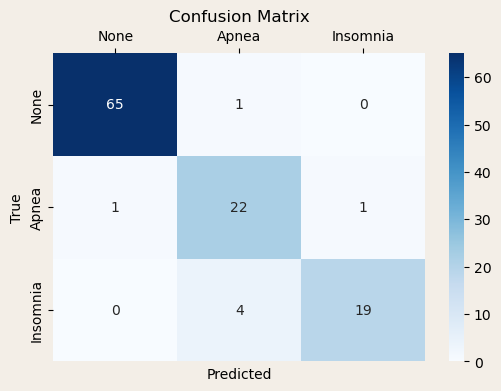

In [157]:
pipeline_mlr.fit(X_train, y_train)

# Generate prediction and show classification report
y_pred = pipeline_mlr.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>High baseline cross validated F1 score 84.5% but higher test accuracy 87.2% almost equaling train accuracy. No sign of overfitting.</li>
    <li>High variation in cross validated scores (6.6%)</li>
    <li>Overall model accuracy is high at ~ 94%.</li>
    <li>There is a precision - accuracy trade off for both positive classes: model making most mistakes at misclassifying Insomnia as Apnea. Apnea has high class recall (coverage) but in doing so has taken in some Insomnia samples, reducing class precision (accuracy). Insomnia has high class accuracy but in doing so has lost some true Insmonia samples. Let's see if tuning can move some of the 4 Insomnia samples incorrectly predicted as Apnea.
</ul>
</div>


In [158]:
# Save baseline pipeline to file  
settings.save_pipeline("best_multinomial_logistic_regression_pipeline.pkl", pipeline_mlr)

*Hyperparam tuning*

*Regularisation*

In [163]:
# set up param grid
param_grid_mlr = {
    'multinomial_logistic_regression__penalty': ['l2', "none"] # l1 not typically used for multinomial due to compuataional and interpretibility challenges
}

# Create and fit GridSearchCV object on train data
grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring=custom_scorer, cv=cv_mlr, n_jobs=-1)
grid_search_mlr.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_mlr, X_train, y_train, X_test, y_test, scorer=base_scorer)


Best Parameters:


,multinomial_logistic_regression__penalty
0,l2


---------------------
Using best parameters
---------------------
Train Score: 87.300 %
Mean CV Train Score: 84.300 % ( +- 6.600 % )
Test Score: 87.200 %


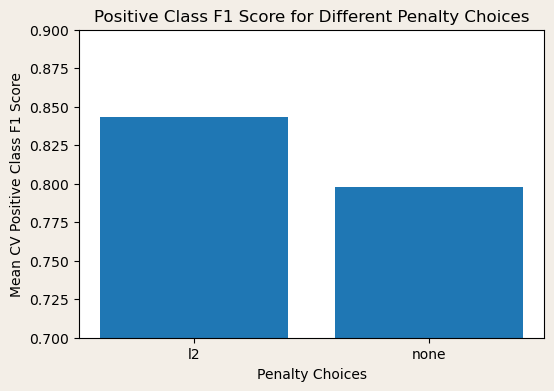

In [168]:
# Access the grid search results
results = grid_search_mlr.cv_results_

# Extract C values and accuracy scores
penalty_values = results['param_multinomial_logistic_regression__penalty'].data
mean_test_scores = results['mean_test_score']

# Plot the accuracy scores against penalty choices
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
ax.bar(penalty_values, mean_test_scores)

# Add plot details
ax.set_ylim(0.7, 0.9)
ax.set_xlabel('Penalty Choices')
ax.set_ylabel('Mean CV Positive Class F1 Score')
ax.set_title('Positive Class F1 Score for Different Penalty Choices')
plt.show()


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Regularisation providing higher score compared to none.</li>
</ul>
</div>


*Perform full param search*

In [169]:
# set up param grid
param_grid_mlr = {
    'multinomial_logistic_regression__C': [0.001, 0.01, 0.1, 1, 10, 100], # default = 1 (moderate)
    'multinomial_logistic_regression__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], # default = lbfgs 
}

# Create and fit GridSearchCV object on train data
grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring=custom_scorer, cv=cv_mlr, n_jobs=-1)
grid_search_mlr.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_mlr, X_train, y_train, X_test, y_test, scorer=base_scorer)


Best Parameters:


,multinomial_logistic_regression__C,multinomial_logistic_regression__solver
0,1,newton-cg


---------------------
Using best parameters
---------------------
Train Score: 87.300 %
Mean CV Train Score: 84.300 % ( +- 6.600 % )
Test Score: 87.200 %


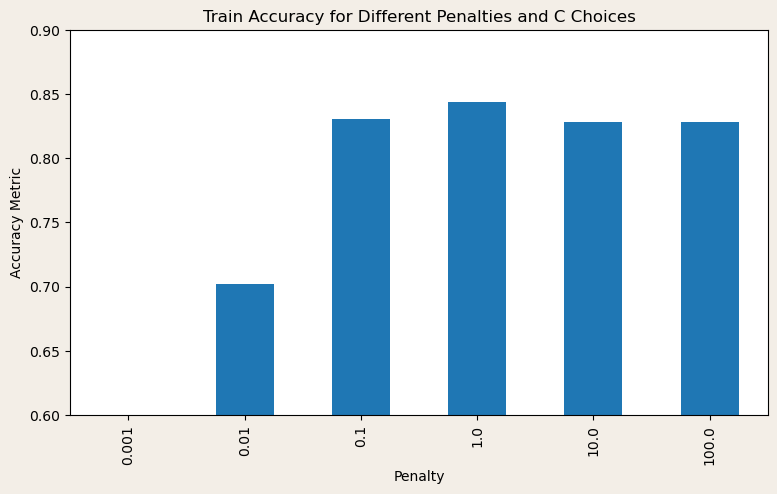

In [185]:
# Access the latest grid search results
results = grid_search_mlr.cv_results_

# Extract penalty, C values and accuracy scores
grouped = pd.DataFrame(results).groupby(["param_multinomial_logistic_regression__C"])["mean_test_score"].mean()

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
grouped.plot(kind='bar', figsize=(9, 5), ax=ax)

# Add plot details
ax.set_ylim(0.6,0.9)
ax.set_xlabel('Penalty')
ax.set_ylabel('Accuracy Metric')
ax.set_title('Train Accuracy for Different Penalties and C Choices')
plt.show()

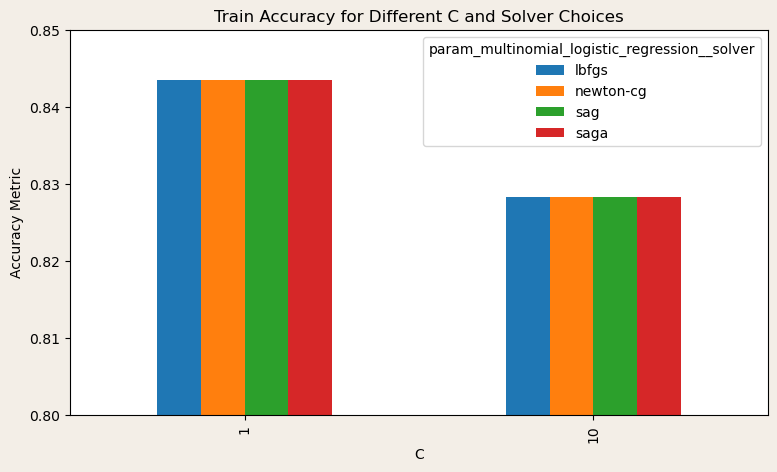

In [173]:
# Extract penalty, C values and accuracy scores
grouped = pd.DataFrame(results)
grouped = grouped[
    ((grouped["param_multinomial_logistic_regression__C"] == 1) | (grouped["param_multinomial_logistic_regression__C"] == 10))
].groupby(["param_multinomial_logistic_regression__C", "param_multinomial_logistic_regression__solver"])["mean_test_score"].mean().unstack()

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
grouped.plot(kind='bar', figsize=(9, 5), ax=ax)

# Add plot details
ax.set_ylim(0.8, 0.85)
ax.set_xlabel('C')
ax.set_ylabel('Accuracy Metric')
ax.set_title('Train Accuracy for Different C and Solver Choices')
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Regularisation providing highest scores in range of 0.1 to 10 but no improvement on baseline in CV or test scores.</li>
    <li>newton-cg identified as best solver although there is no difference in optimal C range: newton first in param list hence why chosen. Default lbfgs will remain.</li>
</ul>
</div>


*Narrow down C param*

In [186]:
# Refine model and update pipeline
model_mlr = LogisticRegression(multi_class='multinomial', solver="lbfgs", penalty="l2", max_iter=1000, random_state=42) 
pipeline_mlr = settings.create_pipeline(["preprocess", column_trans], ["multinomial_logistic_regression", model_mlr])

# set up param grid
param_grid_mlr = {
    'multinomial_logistic_regression__C': np.linspace(0.1, 10, 200), # large sweep of C values
}

# Create and fit GridSearchCV object on train data
grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring=custom_scorer, cv=cv_mlr, n_jobs=-1)
grid_search_mlr.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_mlr, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,multinomial_logistic_regression__C
0,0.846231


---------------------
Using best parameters
---------------------
Train Score: 87.300 %
Mean CV Train Score: 84.300 % ( +- 6.600 % )
Test Score: 87.200 %


<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul style="list-style-type: none; padding-left: 0;">
    <li>No difference in CV or Test score for large sweep of C parameter. Let's stick with default of 1.</li>
</ul>


</div>


*Review metrics for tuned Logistic Regression base model*

Test Accuracy: 93.8100 %

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        66
           1       0.81      0.92      0.86        24
           2       0.95      0.83      0.88        23

    accuracy                           0.94       113
   macro avg       0.92      0.91      0.91       113
weighted avg       0.94      0.94      0.94       113



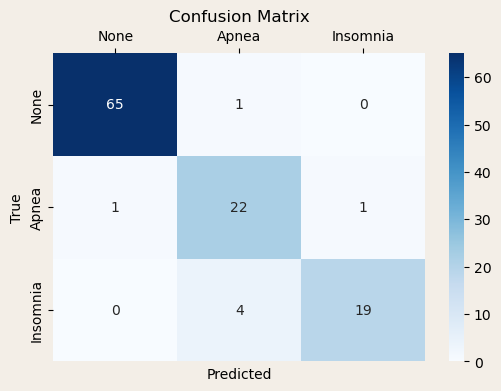

In [188]:
# Print test accuracy
pipeline_mlr.fit(X_train, y_train)
print("Test Accuracy:", settings.score_formatter(pipeline_mlr.score(X_test, y_test), 4))

# Generate prediction and show classification report
y_pred = pipeline_mlr.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

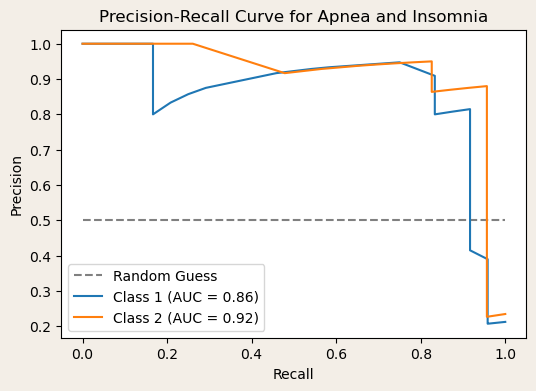

In [203]:
# Calculate probabilities of each class
y_scores = pipeline_mlr.predict_proba(X_test)

# Calculate precision-recall pairs and AUC for each positive class
precision = {}
recall = {}
pr_auc = {}

for class_idx in [1, 2]:  # Select positive classes Apnea and Insomnia
    y_scores_class = y_scores[:, class_idx]
    y_test_class = (y_test == class_idx).astype(int)
    
    precision[class_idx], recall[class_idx], _ = precision_recall_curve(y_test_class, y_scores_class)
    pr_auc[class_idx] = auc(recall[class_idx], precision[class_idx])

# Plot the precision-recall curves for each positive class
plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
plt.plot([0, 1], [0.5, 0.5], linestyle='--', color='gray', label='Random Guess')
for class_idx in [1, 2]:
    plt.plot(recall[class_idx], precision[class_idx], label=f'Class {class_idx} (AUC = {pr_auc[class_idx]:.2f})')
ax.set_ylim(0.0, 1.0)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Apnea and Insomnia')
plt.legend()
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Overall Accuracy of model is very good at 93.8% test set 
    <li>Average AUC on the Precision-Recall of both positive classes is high at 86% of Apnea and 92% for Insmonia showing support for a skillful positive class classifier. A PR curve's theory: when threshold for assigning positive class is very high (~100%), only a few very confident predictions will be make it, resulting in very high precision but very low recall. Conversely, when threshold is very low (~0%), all predictions will make it, resulting in a very high recall but a precision equal to the proportion of that class out of all samples (~25% each for both) </li>
    <li>Class level recall and precision is still as described before.</li>
</ul>
</div>


*Addressing Class Imbalance: Exploring SMOTE-NC*

In [204]:
# instantiate SMOTENC object with categorical indicies of transformed X_train dataset
categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Proving smote object works using the X array transformed by column_trans
from collections import Counter
smote_x, smote_y = smote_nc.fit_resample(transformed_X_train_df, y_train)
print(f"Original class counts: {Counter(y_train)}")
print(f"New class counts: {Counter(smote_y)}")

Original class counts: Counter({0: 153, 2: 54, 1: 54})
New class counts: Counter({2: 153, 1: 153, 0: 153})


In [208]:
# Set up pipeline using imblearn's Pipeline class (SMOTE not compatible with sklearn's Pipeline)
# Reuse model with tuned hyperparameters
steps = [('column_trans', column_trans), ('smote', smote_nc), ('multinomial_logistic_regression', model_mlr)]
pipeline_mlr = Pipeline_imb(steps)

# Fit pipeline
pipeline_mlr.fit(X_train, y_train)

# predict on pipeline (train)
y_pred_train = pipeline_mlr.predict(X_train)

# score pipeline on train
train_score = base_scorer(y_train, y_pred_train)
print('Train Score:', settings.score_formatter(train_score, 3))

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_mlr, X_train, y_train, scoring=custom_scorer, cv=cv_mlr)

print('Mean CV Train Score:', settings.score_formatter(np.mean(cv_scores), 3),
        "( +-", settings.score_formatter(np.std(cv_scores), 3), ")")

# extract model (remove smote for test) and produce test score 
model_mlr = pipeline_mlr.named_steps['multinomial_logistic_regression']

# predict on pipeline (train)
y_pred_test = model_mlr.predict(transformed_X_test_df.values)

# score pipeline on test
test_score = base_scorer(y_test, y_pred_test)
print('Test Score:', settings.score_formatter(test_score, 3))

Train Score: 87.300 %
Mean CV Train Score: 85.700 % ( +- 6.700 % )
Test Score: 87.200 %


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>SMOTE shows slight improvement in CV train score but no improvement in test score.</li>
</ul>
</div>


*Testing new features*

*Binning age and dropping original Age*

In [ ]:
# re-initialise X array for all features before modification
X = df[settings.ALL_FEATURES]

# Bin age to new column and drop age column
X.loc[:,'Age_bin'] = pd.cut(X.loc[:,'Age'], [20, 30, 40, 50, 60], labels=['20s', '30s', '40s', '50s']).astype("object")
settings.examine_values(X).loc["Age_bin",:]
X = X.drop("Age", axis=1)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns),
        ('scale', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns)
    ],
    remainder='passthrough')
    
# create model
model_mlr = LogisticRegression(multi_class='multinomial', max_iter=1000, C=3, random_state=42)

# create sklearn pipeline
pipeline_mlr = settings.create_pipeline(["preprocess", column_trans], ["multinomial_logistic_regression", model_mlr])

# create cross validation object for cross_val_score
cv_mlr = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_mlr, X_train, y_train, scoring=custom_scorer, cv=cv_mlr)

settings.cross_val_summary(pipeline_mlr, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)

*Hyperparam tuning*

In [214]:
# set up param grid
param_grid_mlr = {
    'multinomial_logistic_regression__C': [0.001, 0.01, 0.1, 1, 10, 100], # default = 1 (moderate)
}

# Create and fit GridSearchCV object on train data
grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring=custom_scorer, cv=cv_mlr, n_jobs=-1)
grid_search_mlr.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_mlr, X_train, y_train, X_test, y_test, scorer=base_scorer)


Best Parameters:


,multinomial_logistic_regression__C
0,0.1


---------------------
Using best parameters
---------------------
Train Score: 86.400 %
Mean CV Train Score: 82.800 % ( +- 6.500 % )
Test Score: 84.200 %


In [221]:
# Refine model
model_mlr = grid_search_mlr.best_estimator_.named_steps['multinomial_logistic_regression']

# instantiate SMOTENC object with categorical indicies of transformed X_train dataset
categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Set up pipeline using imblearn's Pipeline class (SMOTE not compatible with sklearn's Pipeline)
# Reuse model with tuned hyperparameters
steps = [('column_trans', column_trans), ('smote', smote_nc), ('multinomial_logistic_regression', model_mlr)]
pipeline_mlr = Pipeline_imb(steps)

# Fit pipeline
pipeline_mlr.fit(X_train, y_train)

# predict on pipeline (train)
y_pred_train = pipeline_mlr.predict(X_train)

# score pipeline on train
train_score = base_scorer(y_train, y_pred_train)
print('Train Score:', settings.score_formatter(train_score, 3))

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_mlr, X_train, y_train, scoring=custom_scorer, cv=cv_mlr)

print('Mean CV Train Score:', settings.score_formatter(np.mean(cv_scores), 3),
        "( +-", settings.score_formatter(np.std(cv_scores), 3), ")")

# extract model (remove smote for test) and produce test score 
model_mlr = pipeline_mlr.named_steps['multinomial_logistic_regression']

# transform X_test to be preprocessed
transformed_X_test_array = column_trans.transform(X_test)

# predict on pipeline (train)
y_pred_test = model_mlr.predict(transformed_X_test_array)

# score pipeline on test
test_score = base_scorer(y_test, y_pred_test)
print('Test Score:', settings.score_formatter(test_score, 3))


Train Score: 85.200 %
Mean CV Train Score: 83.200 % ( +- 8.100 % )
Test Score: 85.400 %


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Age binning doesn't improve on best model</li>
</ul>
</div>


*Dropping highly correlated features (all in one cell due to need for loop)*

In [241]:
# Sample list
drop_list = ["Quality of Sleep", "Stress Level", "Sleep Duration"]

# Generate all possible pairs
all_pairs = list(combinations(drop_list, 2))

# Convert to list for filtering columns in dataframe
all_pairs = [list(pair) for pair in all_pairs]

# Run through baseline, hypertune and SMOTE per loop
for pair in all_pairs:
    
    print("\n\n\n#################################################")
    print(f"Dopping: {pair}")
    print("#################################################")

    X = df[settings.ALL_FEATURES]
    X = X.drop(pair, axis=1)

    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Encode y vector 
    map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
    # apply mapping function
    settings.column_mapper(y_train, "Sleep Disorder", map)
    settings.column_mapper(y_test, "Sleep Disorder", map)

    # reshape labels to 1-D array (vector) 
    y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

    # Create a column transformer for ohe and scaling
    column_trans = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns),
            ('scale', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns)
        ],
        remainder='passthrough')
        
    # create model
    model_mlr = LogisticRegression(multi_class='multinomial', max_iter=1000, C=3, random_state=42)

    # create sklearn pipeline
    pipeline_mlr = settings.create_pipeline(["preprocess", column_trans], ["multinomial_logistic_regression", model_mlr])

    # create cross validation object for cross_val_score
    cv_mlr = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

    # run training cross validation on pipeline 
    cv_scores = cross_val_score(pipeline_mlr, X_train, y_train, scoring=custom_scorer, cv=cv_mlr)

    display('BASELINE SCORES:')
    settings.cross_val_summary(pipeline_mlr, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)

    # set up param grid
    param_grid_mlr = {
    'multinomial_logistic_regression__C': [0.001, 0.01, 0.1, 1, 10, 100], # default = 1 (moderate)
    }

    # Create and fit GridSearchCV object on train data
    grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring=custom_scorer, cv=cv_mlr, n_jobs=-1)
    grid_search_mlr.fit(X_train, y_train)

    display("\nTUNED SCORES:")
    settings.hyperparam_tune_summary(grid_search_mlr, X_train, y_train, X_test, y_test, scorer=base_scorer)

    # Refine model
    model_mlr = grid_search_mlr.best_estimator_.named_steps['multinomial_logistic_regression']

    # instantiate SMOTENC object with categorical indicies of transformed X_train dataset
    categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

    # Set up pipeline using imblearn's Pipeline class (SMOTE not compatible with sklearn's Pipeline)
    # Reuse model with tuned hyperparameters
    steps = [('column_trans', column_trans), ('smote', smote_nc), ('multinomial_logistic_regression', model_mlr)]
    pipeline_mlr = Pipeline_imb(steps)

    # Fit pipeline
    pipeline_mlr.fit(X_train, y_train)

    # predict on pipeline (train)
    y_pred_train = pipeline_mlr.predict(X_train)
    
    display("SMOTE SCORES:")

    # score pipeline on train
    train_score = base_scorer(y_train, y_pred_train)
    print('Train Score:', settings.score_formatter(train_score, 3))

    # run training cross validation on pipeline 
    cv_scores = cross_val_score(pipeline_mlr, X_train, y_train, scoring=custom_scorer, cv=cv_mlr)

    print('Mean CV Train Score:', settings.score_formatter(np.mean(cv_scores), 3),
            "( +-", settings.score_formatter(np.std(cv_scores), 3), ")")

    # extract model (remove smote for test) and produce test score 
    model_mlr = pipeline_mlr.named_steps['multinomial_logistic_regression']

    # transform X_test to be preprocessed
    transformed_X_test_array = column_trans.transform(X_test)

    # predict on pipeline (train)
    y_pred_test = model_mlr.predict(transformed_X_test_array)

    # score pipeline on test
    test_score = base_scorer(y_test, y_pred_test)
    print('Test Score:', settings.score_formatter(test_score, 3))





#################################################
Dopping: ['Quality of Sleep', 'Stress Level']
#################################################


'BASELINE SCORES:'

Train Score: 89.200 %
Mean CV Train Score: 83.7700 % ( +- 5.800 % )
Test Score: 87.200 %


'\nTUNED SCORES:'

Best Parameters:


,multinomial_logistic_regression__C
0,1


---------------------
Using best parameters
---------------------
Train Score: 87.300 %
Mean CV Train Score: 85.000 % ( +- 6.900 % )
Test Score: 87.200 %


'\nSMOTE SCORES:'

Train Score: 87.300 %
Mean CV Train Score: 83.000 % ( +- 7.400 % )
Test Score: 85.400 %



#################################################
Dopping: ['Quality of Sleep', 'Sleep Duration']
#################################################


'BASELINE SCORES:'

Train Score: 87.300 %
Mean CV Train Score: 83.4200 % ( +- 6.300 % )
Test Score: 86.300 %


'\nTUNED SCORES:'

Best Parameters:


,multinomial_logistic_regression__C
0,10


---------------------
Using best parameters
---------------------
Train Score: 89.200 %
Mean CV Train Score: 83.400 % ( +- 6.600 % )
Test Score: 86.300 %


'\nSMOTE SCORES:'

Train Score: 88.300 %
Mean CV Train Score: 81.700 % ( +- 6.400 % )
Test Score: 87.500 %



#################################################
Dopping: ['Stress Level', 'Sleep Duration']
#################################################


'BASELINE SCORES:'

Train Score: 87.300 %
Mean CV Train Score: 83.7400 % ( +- 6.600 % )
Test Score: 86.300 %


'\nTUNED SCORES:'

Best Parameters:


,multinomial_logistic_regression__C
0,1


---------------------
Using best parameters
---------------------
Train Score: 86.400 %
Mean CV Train Score: 84.300 % ( +- 6.600 % )
Test Score: 84.200 %


'\nSMOTE SCORES:'

Train Score: 87.300 %
Mean CV Train Score: 81.800 % ( +- 6.800 % )
Test Score: 86.300 %


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Dropping ['Quality of Sleep', 'Sleep Duration'] suggests a slightly improvement in test score. This warrents a further look.</li>
</ul>
</div>



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97        66
           1       0.79      0.92      0.85        24
           2       0.95      0.87      0.91        23

    accuracy                           0.93       113
   macro avg       0.91      0.91      0.91       113
weighted avg       0.94      0.93      0.93       113



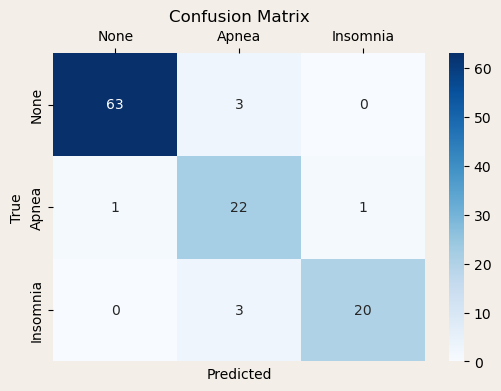

In [245]:
X = df[settings.ALL_FEATURES]
X = X.drop(['Quality of Sleep', 'Sleep Duration'], axis=1)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

# create model
model_mlr = LogisticRegression(multi_class='multinomial', max_iter=1000, C=3, random_state=42)

# create sklearn pipeline
pipeline_mlr = settings.create_pipeline(["preprocess", column_trans], ["multinomial_logistic_regression", model_mlr])

# set up param grid
param_grid_mlr = {
'multinomial_logistic_regression__C': [0.001, 0.01, 0.1, 1, 10, 100], # default = 1 (moderate)
}

# Create and fit GridSearchCV object on train data
grid_search_mlr = GridSearchCV(pipeline_mlr, param_grid=param_grid_mlr, scoring=custom_scorer, cv=cv_mlr, n_jobs=-1)
grid_search_mlr.fit(X_train, y_train)

# Refine model
model_mlr = grid_search_mlr.best_estimator_.named_steps['multinomial_logistic_regression']

# instantiate SMOTENC object with categorical indicies of transformed X_train dataset
categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Set up pipeline using imblearn's Pipeline class (SMOTE not compatible with sklearn's Pipeline)
# Reuse model with tuned hyperparameters
steps = [('column_trans', column_trans), ('smote', smote_nc), ('multinomial_logistic_regression', model_mlr)]
pipeline_mlr = Pipeline_imb(steps)

# Fit pipeline
pipeline_mlr.fit(X_train, y_train)

# extract model (remove smote for test) and produce test score 
model_mlr = pipeline_mlr.named_steps['multinomial_logistic_regression']

# transform X_test to be preprocessed
transformed_X_test_array = column_trans.transform(X_test)

# predict on pipeline (train)
y_pred_test = model_mlr.predict(transformed_X_test_array)

# generate classification report
class_report = classification_report(y_test, y_pred_test)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred_test)

# plot visuals
settings.plot_conf_matrix(class_labels, conf_matrix)


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>There is an interesting precision - accuracy trade off for in this improvement: model has made one less mistake where it classified an Insomnia sample incorrectly as an Apnea sample. Hense Insomnia recall has improved, one of the goals since the baseline model. However, the precision of the Apnea class has decreased simultaniously: two None samples have been newly predicted as Apnea, counteracting the improvement. The F1 score is marginally higher in this new configuration but the precision of Apnea has fallen below 80% for the first time. This more extreme distribution of precision and recall scores within the F1 score is not desirable and won't be considered an improvement on the model.</li>
</ul>
</div>
